In [1]:
#|default_exp xformer

# Transformer

In [2]:
from dataclasses import dataclass
import torch
import matplotlib.pyplot as plt

from torch import nn, optim, tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from functools import partial

import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset
import tiktoken

from miniai.datasets import * 
from miniai.activations import *
from miniai.learner import *
from miniai.conv import * 
from miniai.resnet import *
from miniai.init import * 
from miniai.sgd import *
from miniai.augment import * 

In [3]:
from IPython.core.debugger import set_trace
%load_ext autoreload
%autoreload 2

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
plt.style.use('fast')

In [5]:
name = "tiny_shakespeare"
dsd = load_dataset(name)

Found cached dataset tiny_shakespeare (/home/leourbina/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
tiktoken.list_encoding_names()

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base']

In [10]:
@dataclass
class TConfig:
    epochs = 1
    lr = 5e-3
    batch_size = 128
    ctx_size = 100
    num_workers = 24
    n_embed = 1024
    num_heads = 16
    head_width = n_embed//num_heads
    encoding = 'r50k_base'
    bias = False 
    dropout = 0.2
    fanout = 4 # MLP fanout
    leak = 0.1
    act = partial(GeneralReLU, leak=leak, sub=0.4)
    depth = 4
    max_norm = 1.
    betas = (0.9, 0.95)

In [11]:
def to_dict(conf):
    result = {}
    all_attrs = dir(conf)
    for k in all_attrs:
        if not k.startswith("_"):
            result[k] = getattr(conf, k)
    return result

In [12]:
class TextDataset(Dataset):
    def __init__(self, text, encoder, config: TConfig, **kwargs): 
        self.n_vocab = encoder.n_vocab
        self.text = tensor(encoder.encode_ordinary(text))
        
    def __getitem__(self, i): 
        return self.text[i:i+conf.ctx_size], self.text[i+1:i+conf.ctx_size+1]
    
    def __len__(self): return len(self.text) - conf.ctx_size - 1

In [13]:
gpt_conf = TConfig()
conf = Config("tiny_shakespeare", "GPT", save=True, **to_dict(gpt_conf))

In [14]:
enc = tiktoken.get_encoding(conf.encoding)
train_ds = TextDataset(dsd['train']['text'][0], enc, conf)
valid_ds = TextDataset(dsd['validation']['text'][0], enc, conf)

train_dl = DataLoader(train_ds, batch_size=conf.batch_size, num_workers=conf.num_workers, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=conf.batch_size, num_workers=conf.num_workers)
dls = DataLoaders(train_dl, valid_dl)

In [15]:
xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([128, 100]), torch.Size([128, 100]))

In [16]:
class AttentionHead(nn.Module): # Decoder-only dot product attention
    def __init__(self, config: TConfig):
        super().__init__()
        self.keys = nn.Linear(config.n_embed, config.head_width, bias=False)     # B, T, C -> B, T, H
        self.queries = nn.Linear(config.n_embed, config.head_width, bias=False)  # B, T, C -> B, T, H
        self.values = nn.Linear(config.n_embed, config.head_width, bias=False)   # B, T, C -> B, T, H
        self.register_buffer('tril', torch.tril(torch.ones(config.ctx_size, config.ctx_size))) # T, T
                
    def forward(self, x):
        keys = self.keys(x)
        queries = self.queries(x)
        values = self.values(x)
         
        B, T, C = keys.shape
        cov = queries @ keys.transpose(-2, -1)*C**(-0.5) # (B, T, H) @ (B, C, H) -> (B, T, T) 
        cov.masked_fill_(self.tril == 0, -torch.inf)

        return F.softmax(cov, dim=-1) @ values # (B, T, T) @ (B, T, H) -> (B, T, H)

In [17]:
class MultiHeadAttention(nn.Module): 
    def __init__(self, config: TConfig):
        super().__init__()
        assert config.n_embed % config.num_heads == 0
        self.heads = nn.ModuleList([AttentionHead(config) for _ in range(conf.num_heads)])
        
    def forward(self, x):
        res = torch.cat([head(x) for head in self.heads], dim=-1)        
        return res

In [18]:
class MLP(nn.Module):
    def __init__(self, config: TConfig):
        super().__init__()
        self.lin1 = nn.Linear(config.n_embed, config.n_embed*config.fanout, bias=config.bias)
        self.act = config.act()
        self.lin2 = nn.Linear(config.n_embed*config.fanout, config.n_embed, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, inp):
        x = self.act(self.lin1(inp))
        x = self.dropout(self.lin2(x))
        return inp + x

In [19]:
class Block(nn.Module):
    def __init__(self, config: TConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embed)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)
    
    def forward(self, x): 
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x        

In [20]:
class GPT(nn.Module):
    def __init__(self, vocab_size, config: TConfig):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(vocab_size, config.n_embed, device=device)         #  (B, T, C) token embedding
        self.position_embedding = nn.Embedding(config.ctx_size, config.n_embed, device=device) #  positional embedding
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.depth)])
        self.ln = nn.LayerNorm(config.n_embed)
        self.project = nn.Linear(config.n_embed, vocab_size)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, a=self.config.leak)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0., std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        
    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding(idx) # (B, T, C)
        pos_emb = self.position_embedding(torch.arange(T, device=device)) # (T, C)
        
        x = self.blocks(tok_emb + pos_emb)
        x = self.ln(x)
        x = self.project(x)
        return x

In [21]:
class GPTLearner(Learner):
    def predict(self):
        preds = self.model(self.batch[0])
        B, T, C = preds.shape
        self.preds = preds.view(-1, C)
        self.batch[1] = self.batch[1].view(-1)
    
    def step(self):
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.model.config.max_norm)
        super().step()

In [22]:
gpt = GPT(enc.n_vocab, gpt_conf).to(device)

tmax = conf.epochs * len(dls.train)

astats = ActivationStats(fc.risinstance(GeneralReLU))
metrics = MetricsCB()
sched = BatchSchedCB(partial(optim.lr_scheduler.OneCycleLR, max_lr=conf.lr, total_steps=tmax))
wand = WandBCB(conf, project="GPT")
cbs = [metrics, wand, sched, ProgressCB(plot=True)]

learn = GPTLearner(gpt, dls, F.cross_entropy, cbs=DeviceCB(device=device), opt_func=partial(optim.AdamW, betas=conf.betas))

In [23]:
learn.summary(fc.risinstance(MultiHeadAttention))

Total params: 149234769 - Mflops: 149.2


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
|Embedding|(128, 100)|(128, 100, 1024)|51463168|51.5|
|Embedding|(100,)|(100, 1024)|102400|0.1|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|MultiHeadAttention|(128, 100, 1024)|(128, 100, 1024)|3145728|3.1|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|Linear|(128, 100, 1024)|(128, 100, 4096)|4194304|4.2|
|GeneralReLU|(128, 100, 4096)|(128, 100, 4096)|0|0.0|
|Linear|(128, 100, 4096)|(128, 100, 1024)|4194304|4.2|
|Dropout|(128, 100, 1024)|(128, 100, 1024)|0|0.0|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|MultiHeadAttention|(128, 100, 1024)|(128, 100, 1024)|3145728|3.1|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|Linear|(128, 100, 1024)|(128, 100, 4096)|4194304|4.2|
|GeneralReLU|(128, 100, 4096)|(128, 100, 4096)|0|0.0|
|Linear|(128, 100, 4096)|(128, 100, 1024)|4194304|4.2|
|Dropout|(128, 100, 1024)|(128, 100, 1024)|0|0.0|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|MultiHeadAttention|(128, 100, 1024)|(128, 100, 1024)|3145728|3.1|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|Linear|(128, 100, 1024)|(128, 100, 4096)|4194304|4.2|
|GeneralReLU|(128, 100, 4096)|(128, 100, 4096)|0|0.0|
|Linear|(128, 100, 4096)|(128, 100, 1024)|4194304|4.2|
|Dropout|(128, 100, 1024)|(128, 100, 1024)|0|0.0|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|MultiHeadAttention|(128, 100, 1024)|(128, 100, 1024)|3145728|3.1|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|Linear|(128, 100, 1024)|(128, 100, 4096)|4194304|4.2|
|GeneralReLU|(128, 100, 4096)|(128, 100, 4096)|0|0.0|
|Linear|(128, 100, 4096)|(128, 100, 1024)|4194304|4.2|
|Dropout|(128, 100, 1024)|(128, 100, 1024)|0|0.0|
|LayerNorm|(128, 100, 1024)|(128, 100, 1024)|2048|0.0|
|Linear|(128, 100, 1024)|(128, 100, 50257)|51513425|51.5|


wandb: Currently logged in as: leourbina. Use `wandb login --relogin` to force relogin


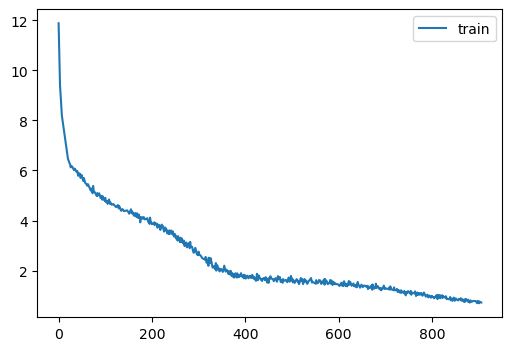

In [ ]:
learn.fit(conf.epochs, cbs=cbs)

In [43]:
model = torch.load("./models/GPT/glad-frost-51")

In [57]:
learn2 = GPTLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)])

In [58]:
learn2.fit(1, train=False, valid=True)

accuracy,loss,epoch,train
0.264,10.585,0,valid
